In [3]:
import os

import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from config_file import data_path

## load and visualize data

In [23]:
dir_with_plays = "plays_per_week"
artist_id = "0a1gHP0HAqALbEyxaD5Ngn"
df = pd.read_csv(os.path.join(data_path, dir_with_plays, f"{artist_id}.csv"), parse_dates=True)
df["data"] = df["year_week"] + "_1"  # add day of week to date (1 - Monday)
df["data"] = pd.to_datetime(df["data"], format="%Y_%W_%w")  # convert to datetime
df.drop("year_week", axis=1, inplace=True)
df.set_index(["data"], inplace=True)
df.head()

,count
data,
2019-07-15,1
2019-07-22,1
2019-07-29,1
2019-08-05,1
2019-08-12,3


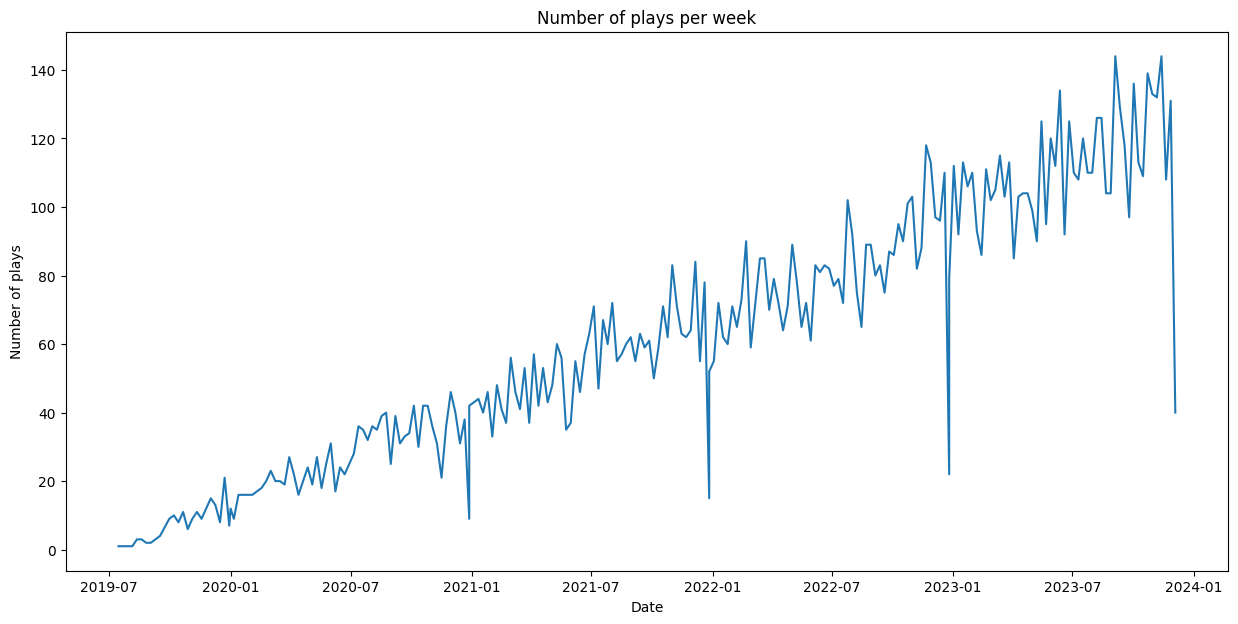

In [25]:
plt.figure(figsize=(15, 7))
plt.title("Number of plays per week")
plt.xlabel('Date')
plt.ylabel('Number of plays')
plt.plot(df)
plt.show()

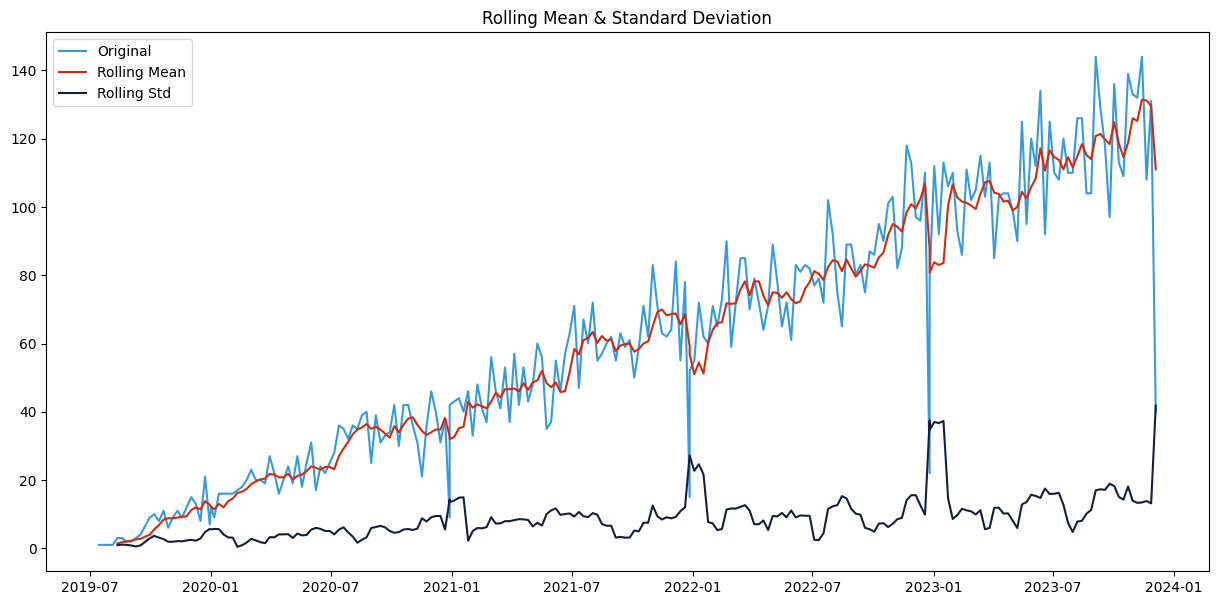

In [32]:
df["rolling_avg"] = df["count"].rolling(window=5).mean()  # 5 weeks ~ 1 month
df["rolling_std"] = df["count"].rolling(window=5).std()

#Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(df["count"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## check stationarity

#### week level

In [33]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -0.313063
p-value                          0.923634
#Lags Used                      15.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


<B>Null Hypothesis:</B> The data is not stationary.

<B>Alternative Hypothesis:</B> The data is stationary.

we cannot reject the null hypothesis, we need to choose model which may handle non-stationary data - eg ARIMA/SARIMA instead of ARMA/SARMA

#### month level

In [37]:
# aggregate data to monthly level
df_month = df.resample('M').sum()
df.drop(["rolling_avg", "rolling_std"], axis=1, inplace=True)
df_month.shape, df.head()

((54, 3),
             count
 data             
 2019-07-15      1
 2019-07-22      1
 2019-07-29      1
 2019-08-05      1
 2019-08-12      3)

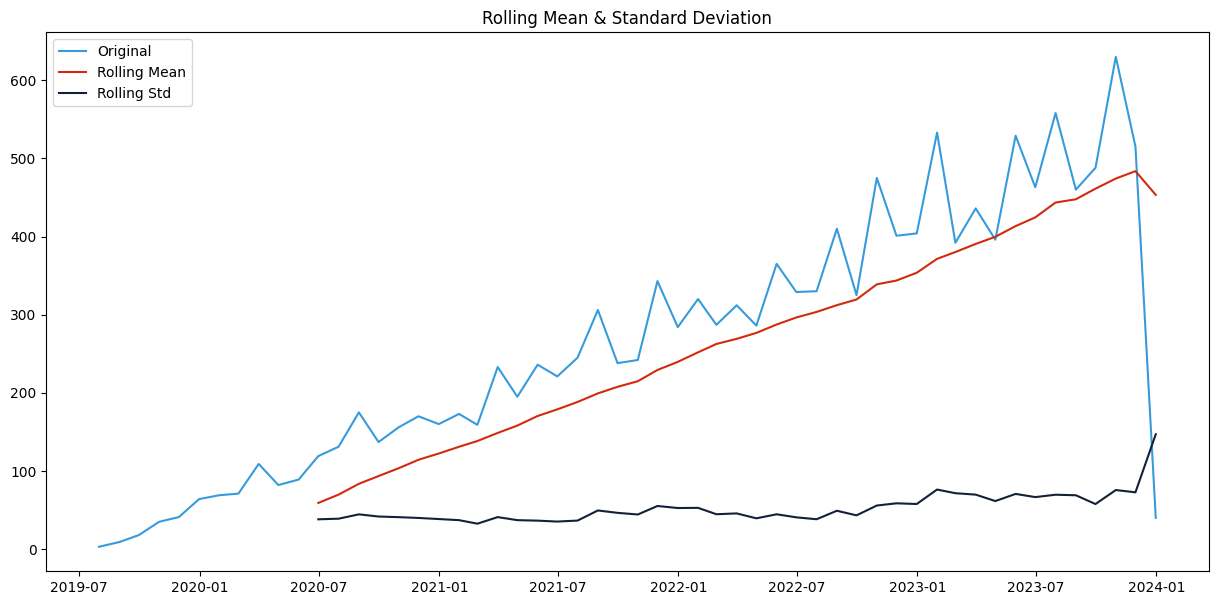

In [43]:
df_month["rolling_avg"] = df_month["count"].rolling(window=12).mean()
df_month["rolling_std"] = df_month["count"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.plot(df_month["count"], color='#379BDB', label='Original')
plt.plot(df_month["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_month["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [44]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_month['count'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.724072
p-value                         0.840416
#Lags Used                     11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


<B>Null Hypothesis:</B> The data is not stationary.

<B>Alternative Hypothesis:</B> The data is stationary.

we cannot reject the null hypothesis, we need to choose model which may handle non-stationary data - eg [ARIMA/SARIMA instead of ARMA/SARMA](https://stats.stackexchange.com/questions/394796/should-my-time-series-be-stationary-to-use-arima-model)

Due to amount of data points we will use weekly data

## SARIMA

#### hiperparameters tuning
**criterion** - AIC (Akaike Information Criterion) -
The AIC is a measure of the relative quality of statistical models for a given set of data. It balances the complexity of the model with how well the model fits the data.
A lower AIC value indicates a better model. A model is considered better if it explains a high amount of variation in the data using a small number of parameters.

**parameters**:
- described in cell below
- search method - provied by pmdarima library - auto_arima - with [stepwise method](https://otexts.com/fpp3/arima-r.html) 

In [45]:
import pandas as pd
from pmdarima import auto_arima

auto_arima_model = auto_arima(
    df["count"], # data
    start_p=1, # number of time lags to include
    start_q=1, # number of previous error terms to include
    max_p=3,
    max_q=3,
    max_d=2, # degrees of differencing to make series stationary
    seasonal=True, # to fit a seasonal ARIMA
    m=52, # the seasonality period; set via domain knowledge and time series plot inspection
    start_P=0, # time lags to include for seasonal component
    start_Q=0, # previous error terms to include for seasonal component
    max_P=2,
    max_Q=2,
    max_D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

# Output the summary of the best SARIMA model
auto_arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1970.153, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1904.818, Time=7.24 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1968.176, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1903.236, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1904.704, Time=1.43 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=7.33 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1889.360, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=1890.520, Time=3.30 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=1890.286, Time=1.93 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=10.23 sec
 ARIMA(3,1,0)(0,0,0)[52] intercept   : AIC=1879.052, Time=0.12 sec
 ARIMA(3,1,0)(1,0,0)[52] intercept   : AIC=1879.227, Time=3.95 sec
 ARIMA(3,1,0)(0,0,1)[52] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  233
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 52)   Log Likelihood                -925.957
Date:                            Tue, 02 Jan 2024   AIC                           1857.913
Time:                                    14:26:47   BIC                           1868.254
Sample:                                         0   HQIC                          1862.084
                                            - 233                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8335      0.040    -20.708      0.000      -0.912      -0.755
ma.S.L52       0.1634      0.081      2.022      0.043       0.005       0.322
sigma2       169.5812      8.262     20.526      0.000     153.388     185.774
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):              2463.86
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               8.29   Skew:                            -2.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model:  ARIMA(0,1,1)(0,0,1)[52]   